<a href="https://colab.research.google.com/github/CristhianSeverino/DataScienceEcomerce/blob/main/Ecomerce_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
#Importar Librerias Necesarias
import pandas as pd
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import plotly.express as px  # Para gráficos 3D interactivos
import warnings
warnings.filterwarnings('ignore')
# Configurar estilo de visualizaciones
sns.set(style="whitegrid")
%matplotlib inline


In [82]:
#1. Importar Datos y Crear Data Frame ====================================

df=pd.read_csv('EcomerceDB.csv')
print("\n=============Importación Exitosa========================")
print("\n=============Estadisticas de la DB Ecomerce========================")
print(df.describe())

print("\n=== Valores faltantes ===")
print(df.isnull().sum())


=============Importación Exitosa========================

=============Estadisticas de la DB Ecomerce========================
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

=== Valores faltantes ===
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [83]:
df=df.dropna(subset=['CustomerID'])
print("\n=== Valores faltantes ===")
print(df.isnull().sum())


=== Valores faltantes ===
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [84]:
print(df['CustomerID'].dtype)
print(df['CustomerID'].unique())

float64
[17850. 13047. 12583. ... 13298. 14569. 12713.]


# **Limpieza de Datos**

>
En este Colab se Hara La limpieza de datos, dado que el Eda y exploracion de algoritmos arrojo, un ingsight relevante, para este caso partuicular las ventas negativas dan informacion sumamente relevante de lo que ocurre en el negocuio


 **Leer el Readme del EDA y del analisis de Algoritmos de Asociacion empleandos**

In [85]:
# Reemplazar los valores NaN en la columna 'Description' con el texto "sin descripción"

df['Description'].fillna('Sin Descripción', inplace=True)

print("\n=== Valores Faltantes  Description===")
print(df.isnull().sum())




=== Valores Faltantes  Description===
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# **Creación de Variables de  Comportamiento**

In [86]:
#2.Crear Variables de Comportamiento del Cliente
#Crear Dataframe
df=df.dropna(subset=['CustomerID'])
df['CustomerID']=df['CustomerID'].astype(str)

#Calcular el Valor total de Cada Transacción
df['Total_Gasto'] =df['Quantity'] * df['UnitPrice']

#Calcular la Frecuencia de compra por Cliente
frecuencia_compra = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frecuencia_compra.columns = ['CustomerID','FrecuenciaCompra']
df=pd.merge(df,frecuencia_compra,on='CustomerID')

#Calcular el Valor Monetario Gastado por Cada cliente
valor_total = df.groupby('CustomerID')['Total_Gasto'].sum().reset_index()
valor_total.columns=['CustomerID','ValorTotal']
df = pd.merge(df,valor_total,on='CustomerID')

#Calcular Ultima Fecha de Compra de Cada Cliente (Recencia)
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
ultima_compra = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
ultima_compra.columns= ['CustomerID','UltimaCompra']
fecha_referencia = df['InvoiceDate'].max() #Toma la ultima fecha del data set como Referencia
ultima_compra['Recencia'] = (fecha_referencia-ultima_compra['UltimaCompra']).dt.days # Calcula diferencia entre dias
df=pd.merge(df,ultima_compra[['CustomerID','Recencia']],on = 'CustomerID')



#Calcular la variedad de productos Comprados Por cliente
variedad_productos = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
variedad_productos.columns=['CustomerID','VariedadProductos']
df=pd.merge(df,variedad_productos, on='CustomerID')

#Calcular la cantidad total de articulos comprados por cliente
cantidad_total=df.groupby('CustomerID')['Quantity'].sum().reset_index()
cantidad_total.columns=['CustomerID','CantidadTotal']
df=pd.merge(df,cantidad_total,on='CustomerID')

#==================================    Calcular métricas relacionadas con transacciones negativas   ========================================
"""
devoluciones = df[df['Quantity'] < 0].groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Frecuencia de devoluciones
    'Total_Gasto': 'sum'     # Monto total de devoluciones
}).reset_index()
devoluciones.columns = ['CustomerID', 'FrecuenciaDevoluciones', 'MontoDevoluciones']

# Combinar con el DataFrame principal
df = pd.merge(df, devoluciones, on='CustomerID', how='left')
df['FrecuenciaDevoluciones'] = df['FrecuenciaDevoluciones'].fillna(0)
df['MontoDevoluciones'] = df['MontoDevoluciones'].fillna(0)

# Añadir estas nuevas features a las variables de segmentación
variables_segmentacion = ['FrecuenciaCompra', 'ValorTotal', 'Recencia', 'VariedadProductos',
                          'CantidadTotal', 'FrecuenciaDevoluciones', 'MontoDevoluciones']
df_segmentacion = df[['CustomerID'] + variables_segmentacion].drop_duplicates(subset=['CustomerID']).set_index('CustomerID')
"""


print("\n==========Data Frame Actualizdo con metricas  Con Exito===============")
print(df.head())


==========Data Frame Actualizdo con metricas  Con Exito===============
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Total_Gasto  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom        15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom        22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   

   FrecuenciaCompra  ValorTotal  Recen

In [87]:
# Añadir estas nuevas features a las variables de segmentación
variables_segmentacion = ['FrecuenciaCompra', 'ValorTotal', 'Recencia', 'VariedadProductos',
                          'CantidadTotal']
df_segmentacion = df[['CustomerID'] + variables_segmentacion].drop_duplicates(subset=['CustomerID']).set_index('CustomerID')


print("\n==========Data Frame Segmentación Creado Con Exito===============")
print(df_segmentacion.head())


==========Data Frame Segmentación Creado Con Exito===============
            FrecuenciaCompra  ValorTotal  Recencia  VariedadProductos  \
CustomerID                                                              
17850.0                   35     5288.63       301                 24   
13047.0                   18     3079.10        31                106   
12583.0                   18     7187.34         2                115   
13748.0                    5      948.25        95                 24   
15100.0                    6      635.10       329                  1   

            CantidadTotal  
CustomerID                 
17850.0              1693  
13047.0              1355  
12583.0              5009  
13748.0               439  
15100.0                58  


In [88]:
# Control de duplicados
# Crear un DataFrame Solo con las Variables de Segmentación y Eliminar Duplicados de Clientes
df_segmentacion=df[['CustomerID']+variables_segmentacion].drop_duplicates(subset=['CustomerID']).set_index('CustomerID')
print(df_segmentacion.head())

            FrecuenciaCompra  ValorTotal  Recencia  VariedadProductos  \
CustomerID                                                              
17850.0                   35     5288.63       301                 24   
13047.0                   18     3079.10        31                106   
12583.0                   18     7187.34         2                115   
13748.0                    5      948.25        95                 24   
15100.0                    6      635.10       329                  1   

            CantidadTotal  
CustomerID                 
17850.0              1693  
13047.0              1355  
12583.0              5009  
13748.0               439  
15100.0                58  


# **Aplicar K-Means**

In [89]:
#Escalar y Transformar Las variables (Incluyendo Transacciones Negativas)
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_segmentacion)
print(  "\n==========   Data Frame Escalado Con Exito   ===============")

#Aplicar PowerTransformer para Manejar Valores Negativops y Distribuciones Sesgadas

#pt = PowerTransformer(method='yeo-johnson')
#df_escalado = pt.fit_transform(df_escalado)
#print("\n==========Data Frame Escalado y Transformado Con Exito===============")



==========   Data Frame Escalado Con Exito   ===============


==================== Grafico de Codo =========================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

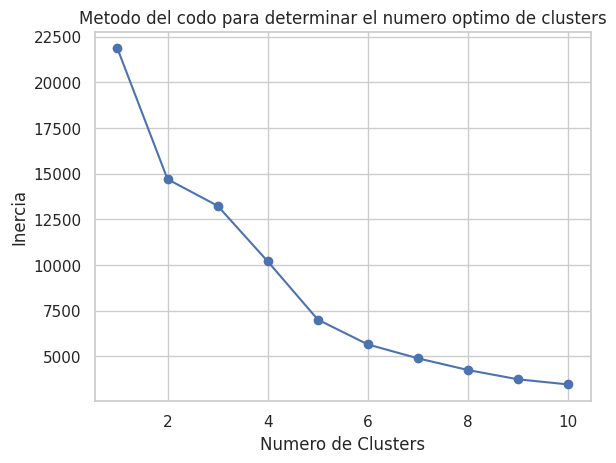

In [90]:
# Aplicar K.Means Generar Grafico del codo
inertia=[]
rango_clusters=range(1,11)
for i in rango_clusters:
    kmeans=KMeans(n_clusters=i,random_state=42,n_init='auto')
    kmeans.fit(df_escalado)
    inertia.append(kmeans.inertia_)


# Grafico de Codo ===================================================================
print("==================== Grafico de Codo =========================")

plt.plot(rango_clusters,inertia,marker='o')
plt.title('Metodo del codo para determinar el numero optimo de clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Inercia')
plt.savefig('codo_plot.png')
files.download('codo_plot.png')
plt.show()





In [91]:
#========================Aplicar K-Means con el numero optimo de clusters =============================================================

n_cluster_optimo = 3
kmeans_final =KMeans(n_clusters=n_cluster_optimo,random_state=42, n_init='auto')
df_segmentacion['segmento_cliente']=kmeans_final.fit_predict(df_escalado)

print(f"========= Se Han implementado {n_cluster_optimo} Clusters ==========")
print(df_segmentacion.head())

========= Se Han implementado 3 Clusters ==========
            FrecuenciaCompra  ValorTotal  Recencia  VariedadProductos  \
CustomerID                                                              
17850.0                   35     5288.63       301                 24   
13047.0                   18     3079.10        31                106   
12583.0                   18     7187.34         2                115   
13748.0                    5      948.25        95                 24   
15100.0                    6      635.10       329                  1   

            CantidadTotal  segmento_cliente  
CustomerID                                   
17850.0              1693                 0  
13047.0              1355                 0  
12583.0              5009                 0  
13748.0               439                 0  
15100.0                58                 0  


Para k=2, la silueta promedio es: 0.924
Para k=3, la silueta promedio es: 0.919
Para k=4, la silueta promedio es: 0.442
Para k=5, la silueta promedio es: 0.511
Para k=6, la silueta promedio es: 0.500
Para k=7, la silueta promedio es: 0.433
Para k=8, la silueta promedio es: 0.427
Para k=9, la silueta promedio es: 0.432
Para k=10, la silueta promedio es: 0.417
========================   Análisis de Silueta para   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

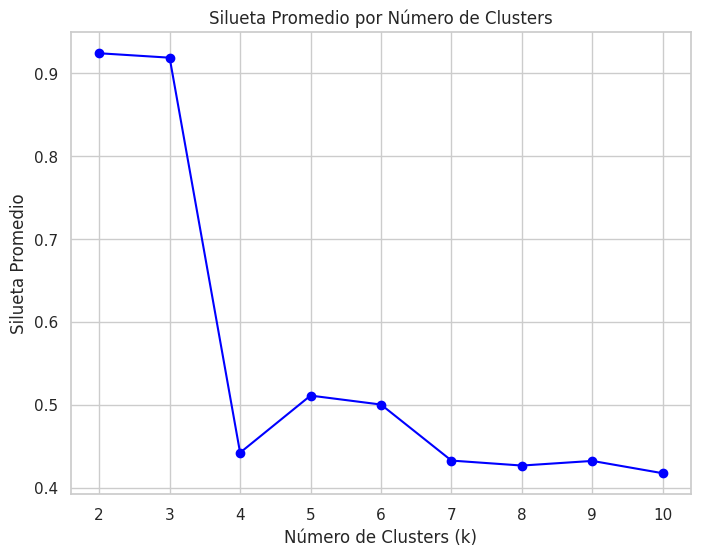

========================   Análisis de Silueta para k=2   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

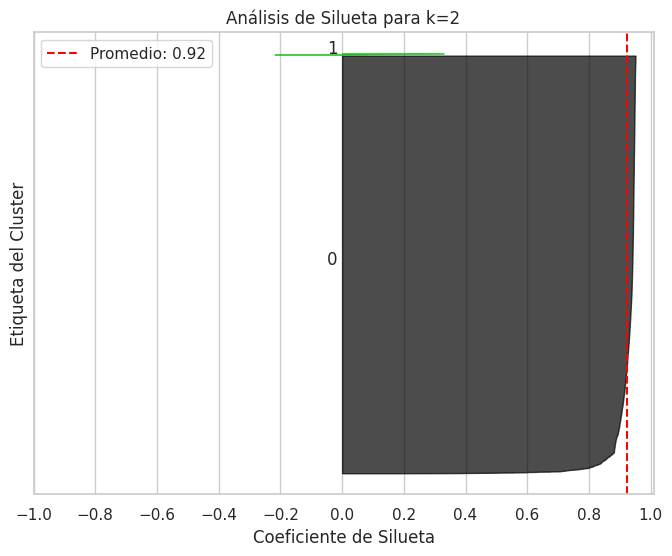

========================   Análisis de Silueta para k=3   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

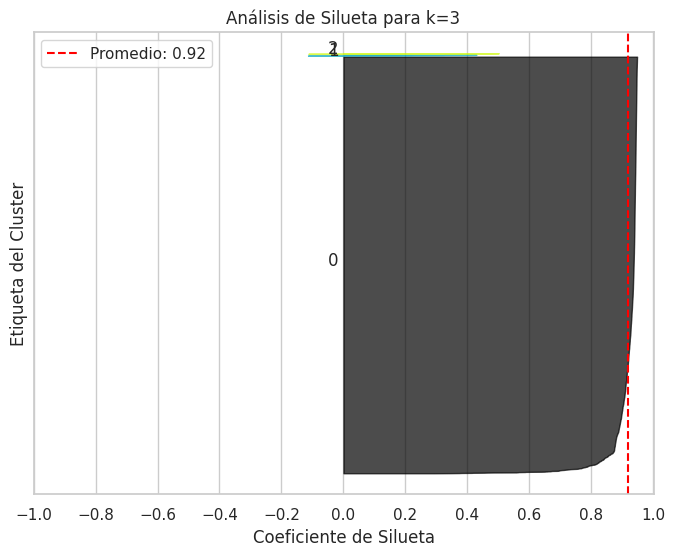

========================   Análisis de Silueta para k=4   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

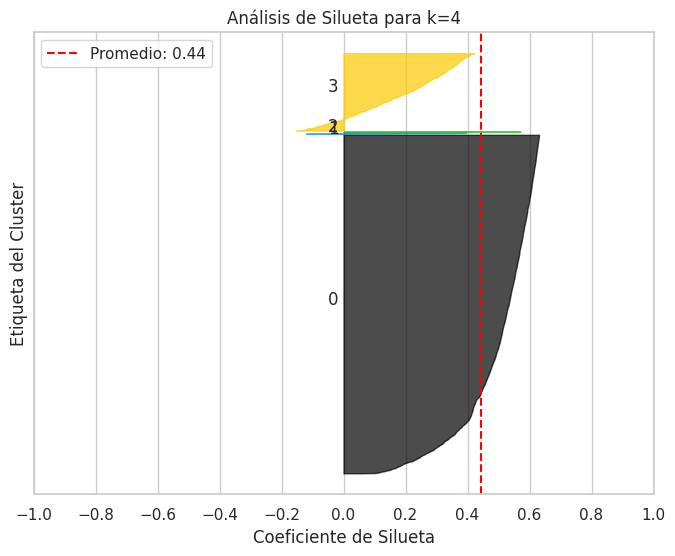

========================   Análisis de Silueta para k=5   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

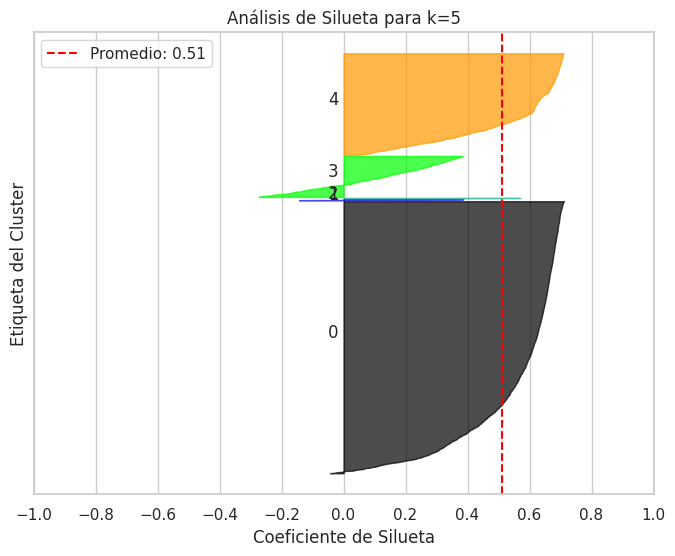

========================   Análisis de Silueta para k=6   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

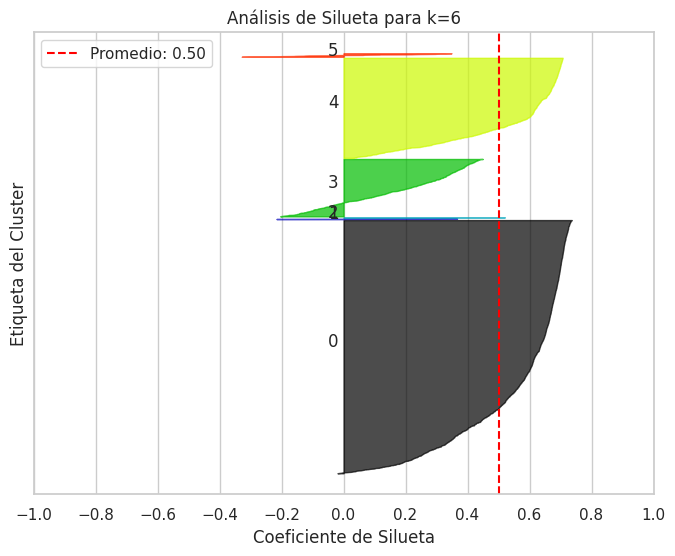

========================   Análisis de Silueta para k=7   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

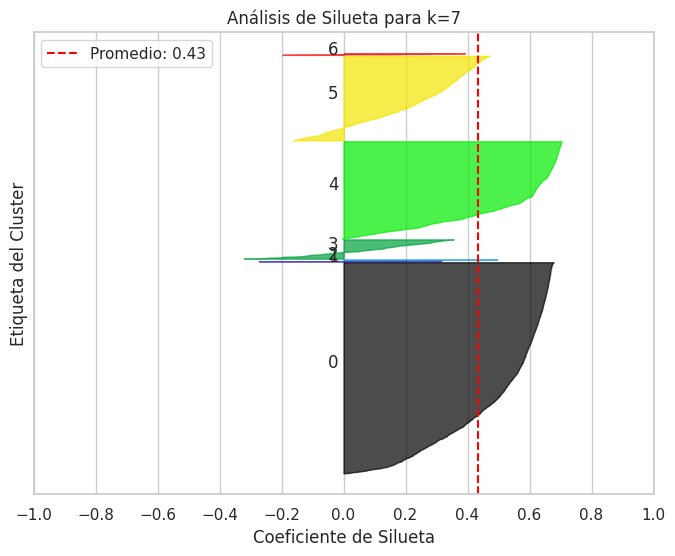

========================   Análisis de Silueta para k=8   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

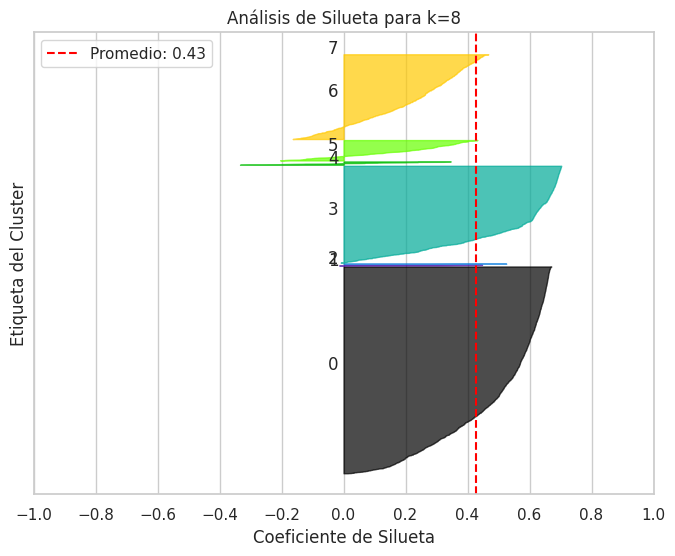

========================   Análisis de Silueta para k=9   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

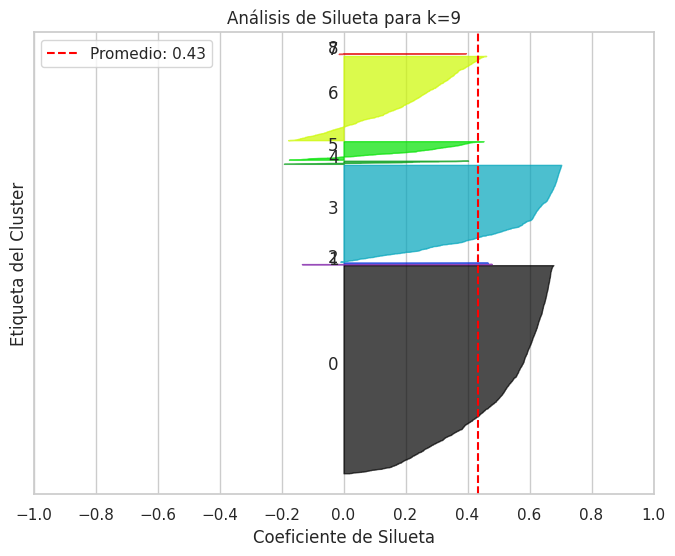

========================   Análisis de Silueta para k=10   ===============================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

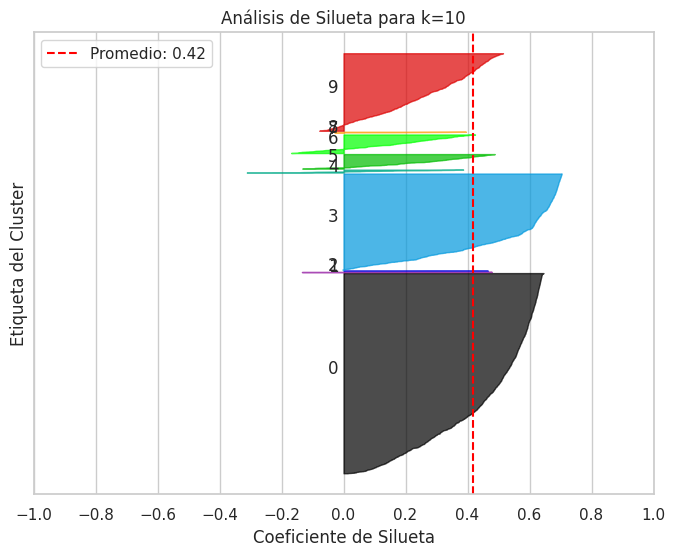

In [92]:
#=================================   Análisis de Silueta   ========================================

sns.set(style="whitegrid")
%matplotlib inline


# 1. Definir el rango de valores de k (número de clusters) a probar
k_range = range(2, 11)  # Probar de 2 a 10 clusters

# 2. Calcular la silueta promedio para cada valor de k
silhouette_scores = []
for k in k_range:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(df_escalado)

    # Calcular la silueta promedio
    silhouette_avg = silhouette_score(df_escalado, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Para k={k}, la silueta promedio es: {silhouette_avg:.3f}")

# 3. Graficar la silueta promedio por número de clusters
print("========================   Análisis de Silueta para   ===============================")
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title('Silueta Promedio por Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silueta Promedio')
plt.grid(True)
plt.xticks(list(k_range))
plt.savefig('Silueta_Promedio_por_Numero_de_Clusters.png')
files.download('Silueta_Promedio_por_Numero_de_Clusters.png')
plt.show()

# 4. Generar gráficos de silueta detallados para cada valor de k
for k in k_range:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(df_escalado)

    # Calcular la silueta promedio y los valores de silueta para cada punto
    silhouette_avg = silhouette_score(df_escalado, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_escalado, cluster_labels)

    # Crear el gráfico de silueta
    plt.figure(figsize=(8, 6))
    y_lower = 10
    for i in range(k):
        # Filtrar los valores de silueta para el cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    print(f"========================   Análisis de Silueta para k={k}   ===============================")
    plt.title(f"Análisis de Silueta para k={k}")
    plt.xlabel("Coeficiente de Silueta")
    plt.ylabel("Etiqueta del Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Promedio: {silhouette_avg:.2f}")
    plt.yticks([])
    plt.xticks(np.arange(-1, 1.1, 0.2))
    plt.legend()
    plt.savefig(f'Silueta_Detallada_k{k}.png')
    files.download(f'Silueta_Detallada_k{k}.png')
    plt.show()

In [93]:
#=====================   Se Fucionan El Dataframe Segmentación y el DataFrame Orihginal ===============================

df_merged =pd.merge(df,df_segmentacion['segmento_cliente'], on ='CustomerID')
print("\n==========Data Frame Merged Con Exito===============")
print(df_merged.head())





==========Data Frame Merged Con Exito===============
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Total_Gasto  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom        15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom        22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom        20.34   

   FrecuenciaCompra  ValorTotal  Recencia  VariedadProdu

In [94]:
#==========================================   Eliminar Duplicados del Dataframe ==================================
print("\n==========Data Frame Merged Con Exito===============")
df_merged.drop_duplicates(subset=['InvoiceNo'])


==========Data Frame Merged Con Exito===============


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Gasto,FrecuenciaCompra,ValorTotal,Recencia,VariedadProductos,CantidadTotal,segmento_cliente
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,35,5288.63,301,24,1693,0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,35,5288.63,301,24,1693,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,18,3079.10,31,106,1355,0
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50,18,3079.10,31,106,1355,0
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047.0,United Kingdom,17.85,18,3079.10,31,106,1355,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406785,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom,58.00,41,25748.35,0,40,12804,0
406787,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777.0,United Kingdom,51.84,41,25748.35,0,40,12804,0
406789,581585,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,2011-12-09 12:31:00,0.39,15804.0,United Kingdom,4.68,19,3848.55,0,170,2515,0
406810,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60,40,10510.00,0,113,2594,0


# **Analisis Grafico**

**Se tendran en cuenta las correlaciones positivas y negativas**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

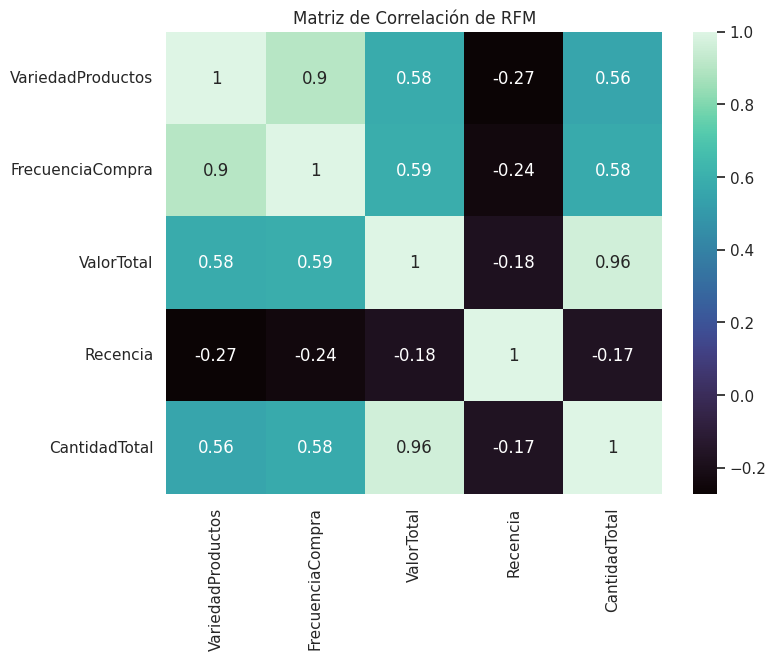

In [95]:
# ================================================  Análisis de correlaciones
# Matriz de correlación para RFM
plt.figure(figsize=(8, 6))
cmap_mako = sns.color_palette("mako", as_cmap=True)
sns.heatmap(df_merged[['VariedadProductos', 'FrecuenciaCompra','ValorTotal','Recencia', 'CantidadTotal']].corr(), annot=True, cmap=cmap_mako)
plt.title('Matriz de Correlación de RFM')
plt.savefig('MatrizDeCorrelacionA.png')
files.download('MatrizDeCorrelacionA.png')
plt.show()


==========   Correlaciones Principales Para Kmeans   ===============

=======================   Cantidad Total vs Valor Total  ==================================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

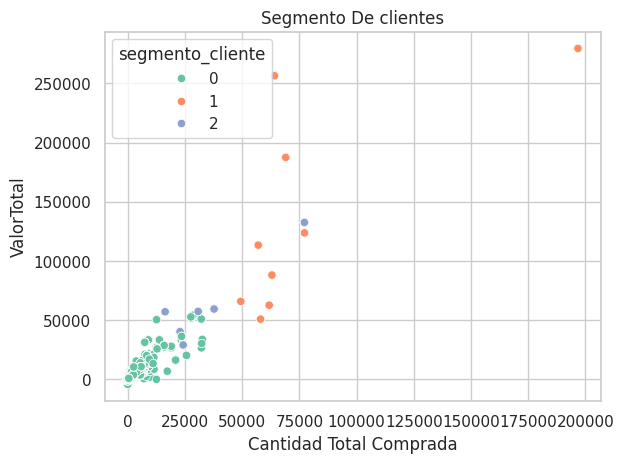


=======================  Frecuencia de Compra vs Variedad de Productos  ==================================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

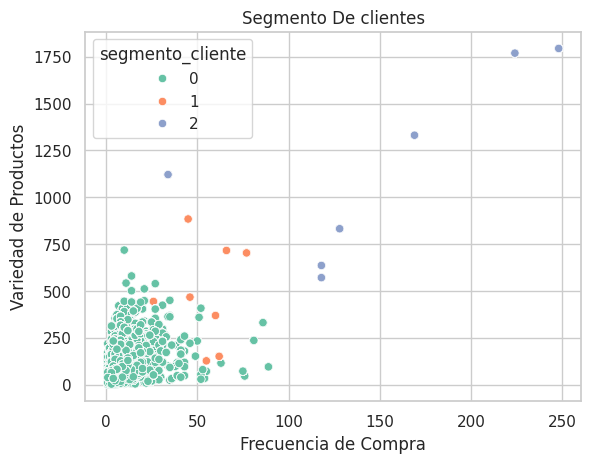


==========   Correlaciones Secundarias   ===============

=======================  Frecuencia de Compra vs Valor Total   ==================================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

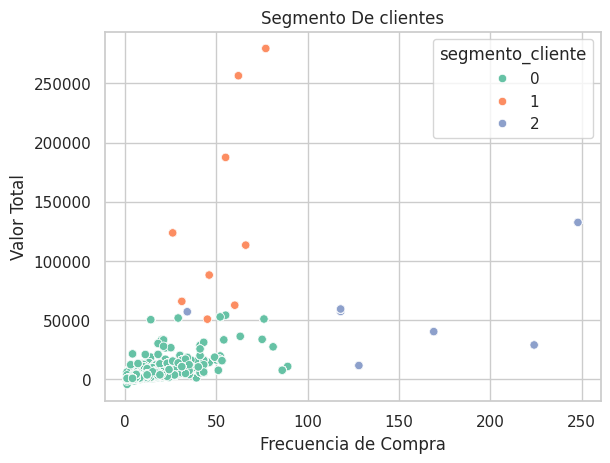


==========   ValorTotal vs Varidad de Productos   ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

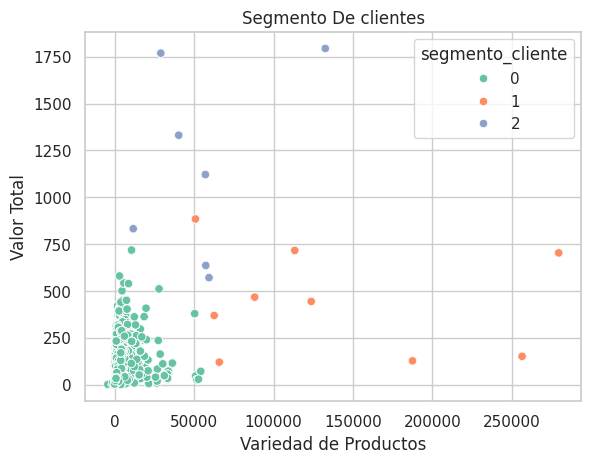


==========   CantidadTotal vs Varidad de Productos   ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

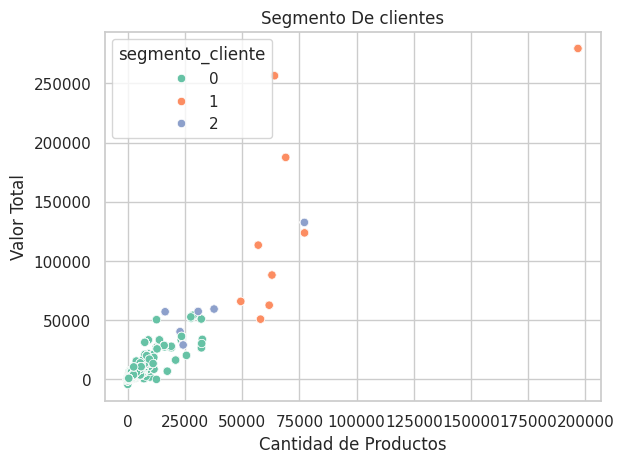


=======================  Frecuencia de Compra vs Cantidad Total   ==================================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

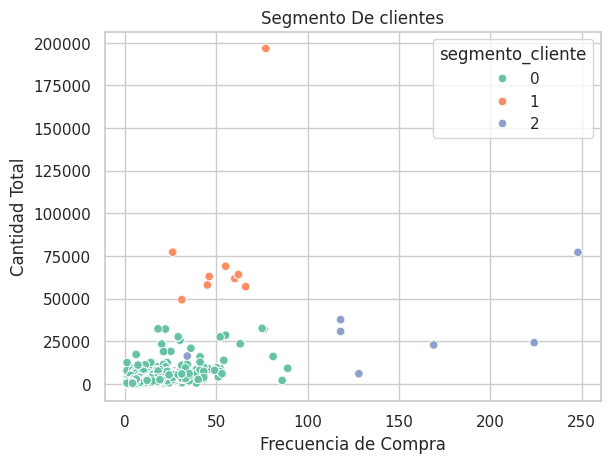

In [96]:

#=========================================   Correlaciones Secundarias   ========================================
print("\n==========   Correlaciones Principales Para Kmeans   ===============")

#Visualizar los Segmentos Cantidad Total vs ValorTotal
print("\n=======================   Cantidad Total vs Valor Total  ==================================")
sns.scatterplot(data=df_merged,x='CantidadTotal',y='ValorTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Cantidad Total Comprada')
plt.ylabel('ValorTotal')
plt.savefig('Cantidad Total vs Valor Total Generado Por Cliente.png')
files.download('Cantidad Total vs Valor Total Generado Por Cliente.png')
plt.show()


#Visualizar los Segmentos Frecuencia de Compra vs Variedad de Productos

print("\n=======================  Frecuencia de Compra vs Variedad de Productos  ==================================")
sns.scatterplot(data=df_merged,x='FrecuenciaCompra',y='VariedadProductos',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Variedad de Productos')
plt.savefig('Frecuencia de Compra vs Variedad de Productos.png')
files.download('Frecuencia de Compra vs Variedad de Productos.png')
plt.show()




#=========================================   Correlaciones Secundarias   ========================================
print("\n==========   Correlaciones Secundarias   ===============")




#================================================================================================
#Visualizar los Segmentos Frecuencia de Compra vs Valor Total

print("\n=======================  Frecuencia de Compra vs Valor Total   ==================================")
sns.scatterplot(data=df_merged,x='FrecuenciaCompra',y='ValorTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Valor Total')
plt.savefig('Frecuencia de Compra vs Valor Total.png')
files.download('Frecuencia de Compra vs Valor Total.png')
plt.show()



#Visualizar los Segmentos Variedad de ValorTotal vs Variedad Productos

print("\n==========   ValorTotal vs Varidad de Productos   ===============")
sns.scatterplot(data=df_merged,x='ValorTotal',y='VariedadProductos',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Variedad de Productos')
plt.ylabel('Valor Total')
plt.savefig('Variedad de Productos vs Valor Total.png')
files.download('Variedad de Productos vs Valor Total.png')
plt.show()



#Visualizar los Segmentos Variedad de CantidadTotal vs Variedad Productos

print("\n==========   CantidadTotal vs Varidad de Productos   ===============")
sns.scatterplot(data=df_merged,x='CantidadTotal',y='ValorTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Cantidad de Productos')
plt.ylabel('Valor Total')
plt.savefig('Cantidad Total vs Valor Total.png')
files.download('Cantidad Total vs Valor Total.png')
plt.show()




#Visualizar los Segmentos Frecuencia de Compra vs Cantidad Total

print("\n=======================  Frecuencia de Compra vs Cantidad Total   ==================================")
sns.scatterplot(data=df_merged,x='FrecuenciaCompra',y='CantidadTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Cantidad Total')
plt.savefig('Frecuencia de Compra Vs Cantidad Total.png')
files.download('Frecuencia de Compra Vs Cantidad Total.png')
plt.show()








==========  Correlaciones Negativas   ===============

==========   Recencia Vs Valor Total Gastado Por Cliente  ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

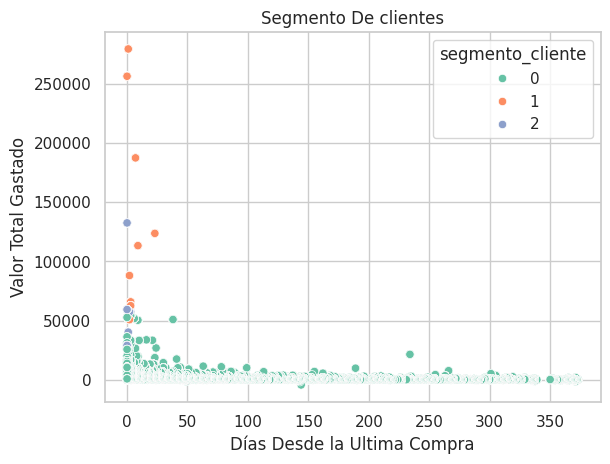


==========   Recencia Vs Cantidad Total   ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

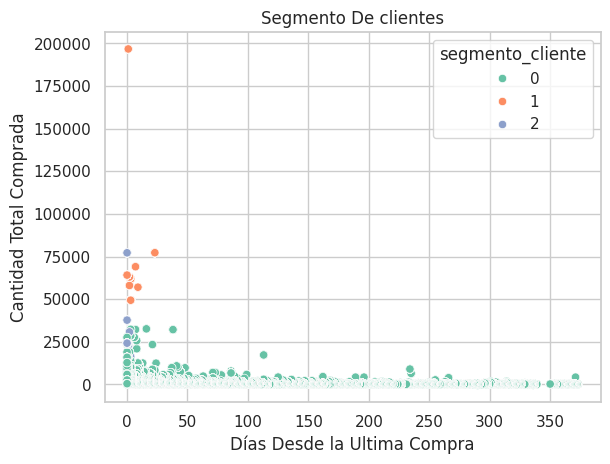


==========   Recencia Vs Frecuencia de Compra   ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

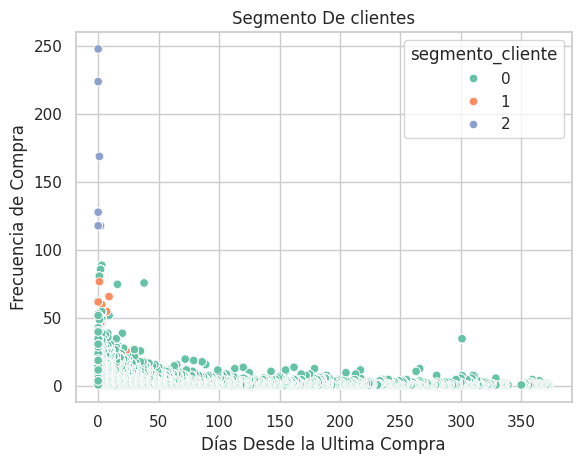


==========   Recencia Vs Variedad de Productos   ===============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

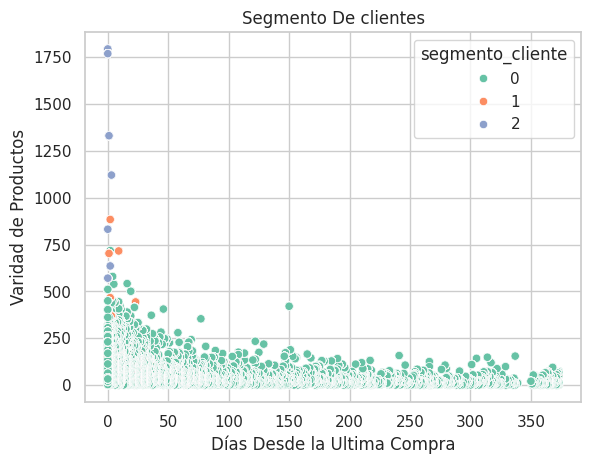

In [97]:
#===================================   Correlaciones Negativas   =============================

print("\n==========  Correlaciones Negativas   ===============")


#Visualizar los Segmentos Recencia vs Valor Total
print("\n==========   Recencia Vs Valor Total Gastado Por Cliente  ===============")
sns.scatterplot(data=df_merged,x='Recencia',y='ValorTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Días Desde la Ultima Compra')
plt.ylabel('Valor Total Gastado')
plt.savefig('Recencia vs Valor Total.png')
files.download('Recencia vs Valor Total.png')
plt.show()


#Visualizar los Segmentos Recencia vs Cantidad Total
print("\n==========   Recencia Vs Cantidad Total   ===============")
sns.scatterplot(data=df_merged,x='Recencia',y='CantidadTotal',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Días Desde la Ultima Compra')
plt.ylabel('Cantidad Total Comprada')
plt.savefig('Recencia vs Cantidad Total.png')
files.download('Recencia vs Cantidad Total.png')
plt.show()


#Visualizar los Segmentos Recencia vs Frecuencia de Compra
print("\n==========   Recencia Vs Frecuencia de Compra   ===============")
sns.scatterplot(data=df_merged,x='Recencia',y='FrecuenciaCompra',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Días Desde la Ultima Compra')
plt.ylabel('Frecuencia de Compra')
plt.savefig('Recencia vs Frecuencia de Compra.png')
files.download('Recencia vs Frecuencia de Compra.png')
plt.show()



#Visualizar los Segmentos Recencia vs Variedad de Productos
print("\n==========   Recencia Vs Variedad de Productos   ===============")
sns.scatterplot(data=df_merged,x='Recencia',y='VariedadProductos',hue='segmento_cliente',palette='Set2')
plt.title('Segmento De clientes')
plt.xlabel('Días Desde la Ultima Compra')
plt.ylabel('Varidad de Productos')
plt.savefig('Recencia vs Variedad de Productos.png')
files.download('Recencia vs Variedad de Productos.png')
plt.show()



==========  BoxPlots   ===============
===============   Box Plot de VariedadProductos por Cluster   =============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

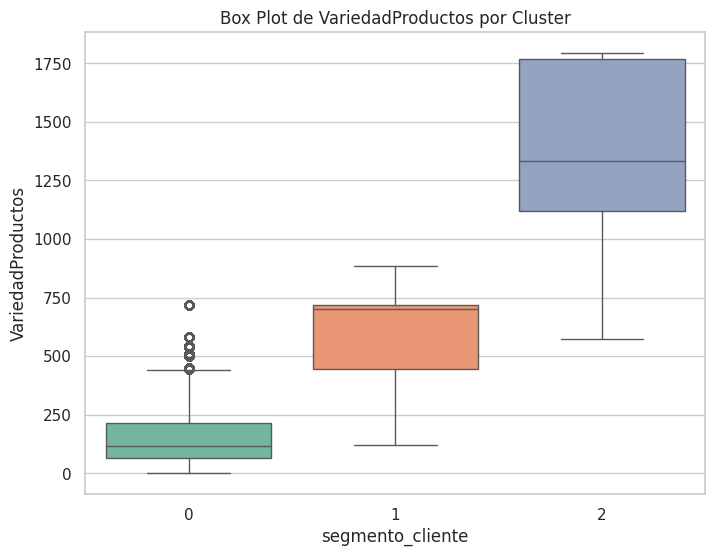

===============   Box Plot de FrecuenciaCompra por Cluster   =============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

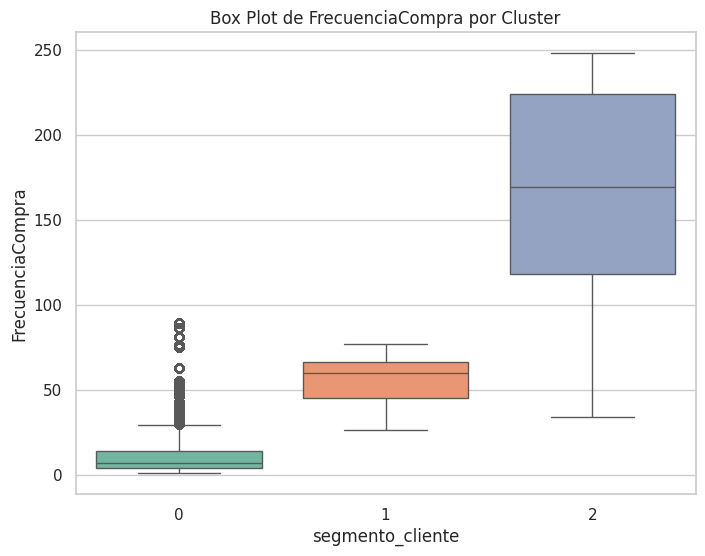

===============   Box Plot de ValorTotal por Cluster   =============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

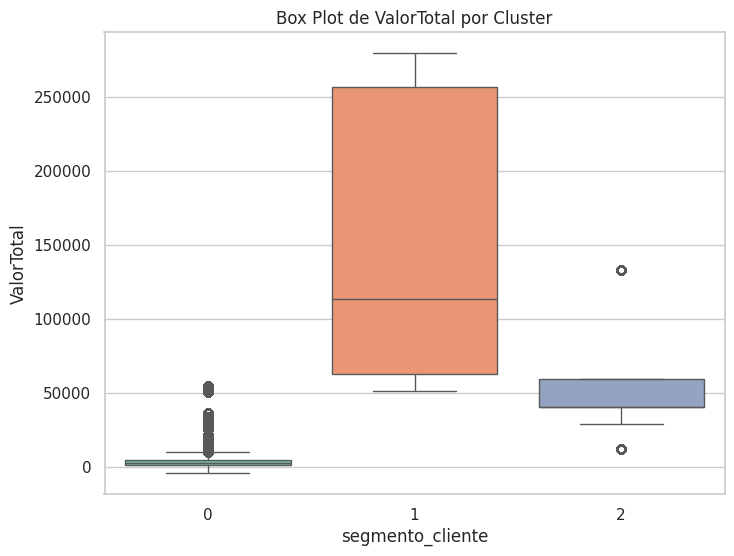

===============   Box Plot de Recencia por Cluster   =============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

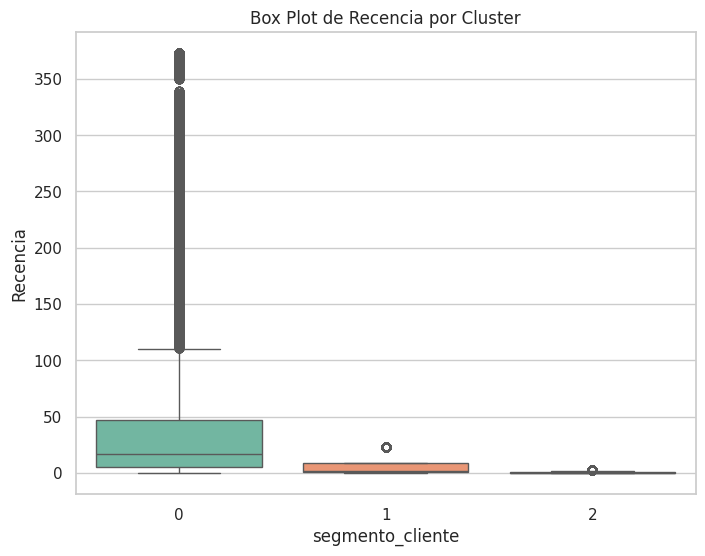

===============   Box Plot de CantidadTotal por Cluster   =============


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

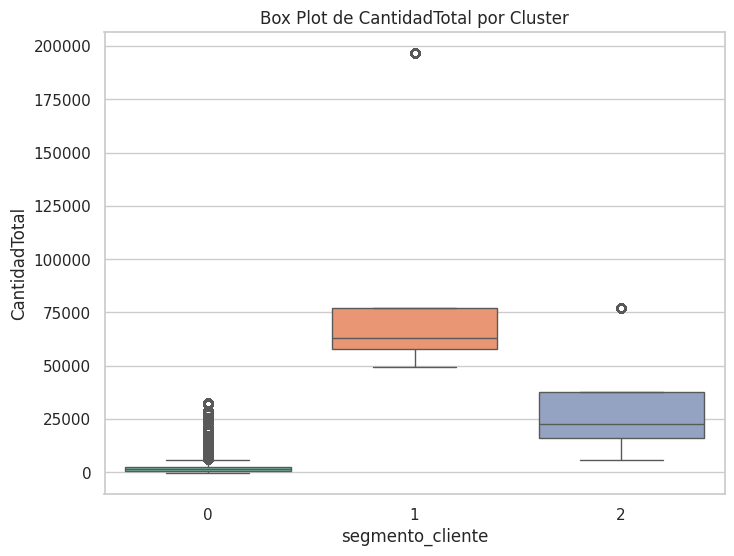

In [99]:
#=======================================   BoxPlots   ============================================

print("\n==========  BoxPlots   ===============")
variables_rfm_cols = ['VariedadProductos', 'FrecuenciaCompra', 'ValorTotal', 'Recencia', 'CantidadTotal']
for var in variables_rfm_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='segmento_cliente', y=var, data=df_merged, palette='Set2')
    print(f"===============   Box Plot de {var} por Cluster   =============")
    plt.title(f'Box Plot de {var} por Cluster')
    plt.xlabel('segmento_cliente')
    plt.ylabel(var)
    plt.savefig(f'Box Plot de {var} por Cluster.png')
    files.download(f'Box Plot de {var} por Cluster.png')
    plt.show()

In [100]:
df_merged['segmento_cliente'] = df_merged['segmento_cliente'].fillna('NaN_Value').astype(str)
print(df_merged['segmento_cliente'].dtype)
print(df_merged['segmento_cliente'].head()) # Ver las primeras filas después del llenado
df_merged['segmento_cliente'] = df_merged['segmento_cliente'].astype(str)
print(df_merged['segmento_cliente'].dtype)

object
0    0
1    0
2    0
3    0
4    0
Name: segmento_cliente, dtype: object
object


In [101]:
print(df_merged.dtypes)

InvoiceNo                    object
StockCode                    object
Description                  object
Quantity                      int64
InvoiceDate          datetime64[ns]
UnitPrice                   float64
CustomerID                   object
Country                      object
Total_Gasto                 float64
FrecuenciaCompra              int64
ValorTotal                  float64
Recencia                      int64
VariedadProductos             int64
CantidadTotal                 int64
segmento_cliente             object
dtype: object


La columna 'Quantity' parece ser completamente numérica.
La columna 'UnitPrice' parece ser completamente numérica.
La columna 'Total_Gasto' parece ser completamente numérica.
La columna 'FrecuenciaCompra' parece ser completamente numérica.
La columna 'ValorTotal' parece ser completamente numérica.
La columna 'Recencia' parece ser completamente numérica.
La columna 'VariedadProductos' parece ser completamente numérica.
La columna 'CantidadTotal' parece ser completamente numérica.


FileNotFoundError: Cannot find file: Parallel Variables Segementación.png

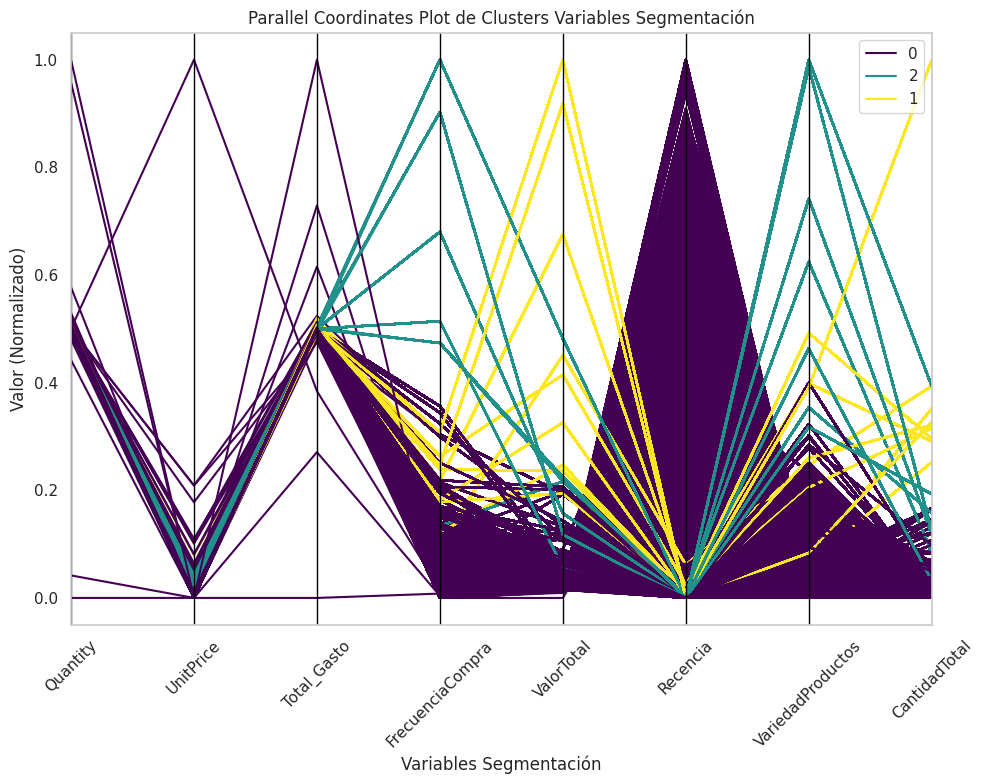

In [102]:
columnas_segmentacion = ['Quantity', 'UnitPrice', 'Total_Gasto', 'FrecuenciaCompra', 'ValorTotal', 'Recencia', 'VariedadProductos', 'CantidadTotal']
for col in columnas_segmentacion:
    try:
        pd.to_numeric(df_merged[col], errors='raise')
        print(f"La columna '{col}' parece ser completamente numérica.")
    except ValueError as e:
        print(f"Error: La columna '{col}' contiene valores no numéricos: {e}")
        print(df_merged[pd.to_numeric(df_merged[col], errors='coerce').isna()][col])


# Convertir 'segmento_cliente' a tipo str para que parallel_coordinates lo acepte
df_merged['segmento_cliente'] = df_merged['segmento_cliente'].astype(str)
from pandas.plotting import parallel_coordinates

# Crear el DataFrame para el gráfico de coordenadas paralelas
# Solo necesitamos las columnas de segmentación + 'segmento_cliente'
df_parallel = df_merged[columnas_segmentacion + ['segmento_cliente']].copy()
# Normalizar las columnas numéricas para que tengan la misma escala (mejora la visualización)
for col in columnas_segmentacion:
    df_parallel[col] = (df_parallel[col] - df_parallel[col].min()) / (df_parallel[col].max() - df_parallel[col].min())

# Generar el gráfico de coordenadas paralelas
plt.figure(figsize=(10, 8))
parallel_coordinates(df_parallel, class_column='segmento_cliente', colormap='viridis')
plt.title('Parallel Coordinates Plot de Clusters Variables Segmentación')
plt.xlabel('Variables Segmentación')
plt.ylabel('Valor (Normalizado)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Parallel Variables Segementación.png')
files.download('Parallel Variables Segementación.png')




 ========================   Clientes Por Segmento   ==============================
segmento_cliente
0    4356
1       9
2       7
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

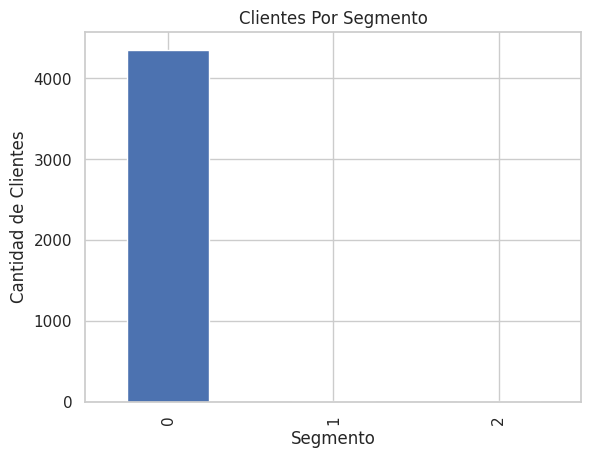

In [105]:
#Analizar y Visualizar Los Segmentos
print("\n ========================   Clientes Por Segmento   ==============================")
print(df_segmentacion['segmento_cliente'].value_counts())
df_segmentacion['segmento_cliente'].value_counts().plot(kind='bar')
plt.title('Clientes Por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Cantidad de Clientes')
plt.savefig('Clientes Por Segmento.png')
files.download('Clientes Por Segmento.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

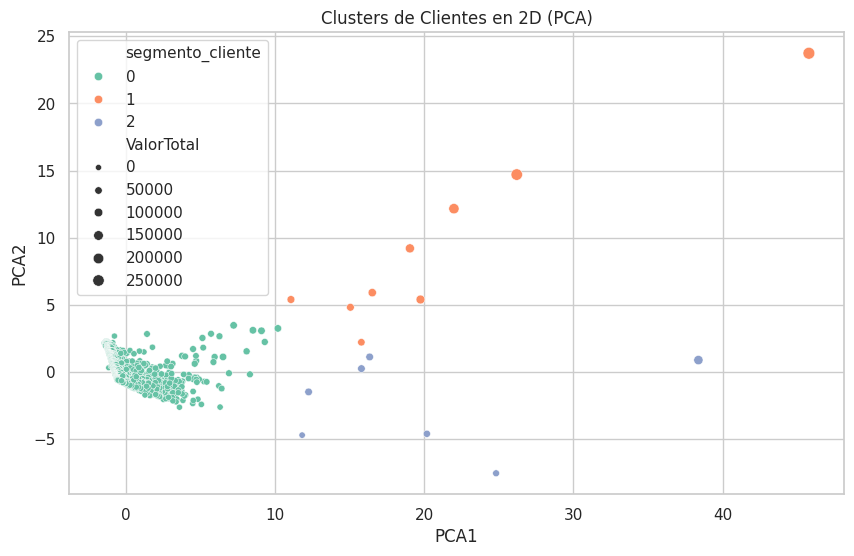

In [107]:
# 6. Visualización de clusters
# Reducir dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_escalado)
df_segmentacion['PCA1'] = X_pca[:, 0]
df_segmentacion['PCA2'] = X_pca[:, 1]

# Scatter plot 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='segmento_cliente', size='ValorTotal', data=df_segmentacion, palette='Set2')
plt.title('Clusters de Clientes en 2D (PCA)')
plt.savefig('clusters_2d.png')  # Guardar para portafolio
files.download('clusters_2d.png')
plt.show()

In [108]:
min_valor = df_segmentacion['ValorTotal'].min()
if min_valor < 0:
    df_segmentacion['ValorTotal_Pos'] = df_segmentacion['ValorTotal'] + abs(min_valor)
else:
    df_segmentacion['ValorTotal_Pos'] = df_segmentacion['ValorTotal']
df_segmentacion.describe()

,FrecuenciaCompra,ValorTotal,Recencia,VariedadProductos,CantidadTotal,segmento_cliente,PCA1,PCA2,ValorTotal_Pos
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4.372000e+03,4372.000000,4372.000000
mean,5.075480,1898.459701,91.047118,61.211116,1122.344007,0.005261,2.600339e-17,0.000000,6186.089701
std,9.338754,8219.345141,100.765435,85.425119,4672.790720,0.091854,1.703972e+00,1.023505,8219.345141
min,1.000000,-4287.630000,0.000000,1.000000,-303.000000,0.000000,-1.427789e+00,-7.525862,0.000000
25%,1.000000,293.362500,16.000000,15.000000,153.000000,0.000000,-6.358686e-01,-0.605359,4580.992500
50%,3.000000,648.075000,49.000000,35.000000,365.000000,0.000000,-3.308998e-01,-0.294547,4935.705000
75%,5.000000,1611.725000,142.000000,77.000000,962.250000,0.000000,2.199435e-01,0.473039,5899.355000
max,248.000000,279489.020000,373.000000,1794.000000,196719.000000,2.000000,4.577300e+01,23.737741,283776.650000


In [110]:

# ========== Aplicar PCA a 3 Componentes ================================
# Configurar estilo de visualizaciones
sns.set(style="whitegrid")
%matplotlib inline

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(df_escalado)

# Crear nuevas columnas en df_merged para los componentes PCA
df_segmentacion['PCA1_3D'] = X_pca_3d[:, 0]
df_segmentacion['PCA2_3D'] = X_pca_3d[:, 1]
df_segmentacion['PCA3_3D'] = X_pca_3d[:, 2]

fig = px.scatter_3d(
    df_segmentacion,
    x='PCA1_3D',
    y='PCA2_3D',
    z='PCA3_3D',
    color='segmento_cliente',
    size='ValorTotal_Pos',
    title='Clusters de Clientes en 3D (PCA)',
    opacity=0.7
)
fig.write_html("clusters_3d_pca.html")
files.download("clusters_3d_pca.html")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Creación de Descargables para Analisis posterior**

>Aplicacion de ETS para Informe



In [113]:
#===========================   Descargables   ==========================================

#Guardar el conteo de clientes por segmento

segmento_counts= df_segmentacion['segmento_cliente'].value_counts().reset_index()
segmento_counts.columns=['Segmento','CantidadClientes']
segmento_counts.to_csv('Conteo de Segmentos.csv')
files.download('Conteo de Segmentos.csv')
print("=======================   Conteo de Segmentos Guardado con Exito   ========================")



# Guardar las características promedio por segmento
segmento_means = df_segmentacion.groupby('segmento_cliente')[variables_segmentacion].mean().reset_index()
segmento_means.to_csv('PromediosSegementos.csv', index=False)
files.download('PromediosSegementos.csv')
print("=======================   Promedios Por Segmentos Guardado con Exito   ========================")


# Guardar el DataFrame df_segmentacion en un archivo CSV

df_segmentacion.to_csv('Segmentacion.csv')
files.download('Segmentacion.csv')
print("=======================   Segmentacion Guardado con Exito   ========================")


# Opcional: Guardar el DataFrame fusionado Analisis Detallado

df_merged.to_csv('Original Actualizado con Kmeans.csv')
files.download('Original Actualizado con Kmeans.csv')
print("=======================   Original Actualizado con Kmeans Guardado con Exito   ========================")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=======================   Conteo de Segmentos Guardado con Exito   ========================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=======================   Promedios Por Segmentos Guardado con Exito   ========================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=======================   Segmentacion Guardado con Exito   ========================


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=======================   Original Actualizado con Kmeans Guardado con Exito   ========================


In [ ]:
# Asumo que 'df_merged' ya está definido
"""
def plot_pca_segments(df, cols, title, filename, pca_prefix):

    #Realiza PCA en las columnas especificadas y visualiza los segmentos de clientes.

    #Args:
        #df (pd.DataFrame): DataFrame con los datos.
        #cols (list): Lista de nombres de columnas para aplicar PCA.
        #title (str): Título del gráfico.
        #filename (str): Nombre del archivo para guardar el gráfico.
        #pca_prefix (str): Prefijo para los nombres de las columnas PCA creadas.

    X_subset = df[cols]
    scaler_subset = StandardScaler()
    X_scaled_subset = scaler_subset.fit_transform(X_subset)
    pca_subset = PCA(n_components=2)
    X_pca_subset = pca_subset.fit_transform(X_scaled_subset)

    df[f'{pca_prefix}_1'] = X_pca_subset[:, 0]
    df[f'{pca_prefix}_2'] = X_pca_subset[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'{pca_prefix}_1', y=f'{pca_prefix}_2', hue='segmento_cliente', data=df, palette='Set2')
    plt.title(title)
    plt.xlabel(f'PCA Componente 1 ({", ".join(cols)})')
    plt.ylabel(f'PCA Componente 2 ({", ".join(cols)})')
    plt.savefig(filename)
    plt.show()

    print(f"\n=== Componentes PCA de {', '.join(cols)} ===")
    print(pca_subset.components_)

#============================================   Grafico 2D   ================================================================

#Grafico 1
plot_pca_segments(df_merged,
                    ['CantidadTotal', 'ValorTotal'],
                    'Segmentos de Clientes en 2D (PCA de Cantidad Total y Valor Total)',
                    'Segmentos de Clientes en 2D (PCA de Cantidad Total y Valor Total.png',
                    'PCA_CantidadValor')

#================================================================================================
#Grafico 2
plot_pca_segments(df_merged,
                    ['VariedadProductos', 'FrecuenciaDevoluciones'],
                    'Segmentos de Clientes en 2D (PCA de Variedad Productos y Frecuencia de Devoluciones)',
                    'Segmentos de Clientes en 2D (PCA de Variedad Productos y FrecuenciaDevoluciones.png',
                    'PCA_ProdDev')

#======================================================================================
#Grafico 3
plot_pca_segments(df_merged,
                    ['FrecuenciaCompra', 'FrecuenciaDevoluciones'],
                    'Segmentos de Clientes en 2D (PCA de Frecuencia de Compra y Frecuencia de Devoluciones)',
                    'Segmentos de Clientes en 2D (PCA de Frecuencia de Compra y FrecuenciaDevoluciones.png',
                    'PCA_CompraDev')

#======================================================================================
#Grafico 4
plot_pca_segments(df_merged,
                    ['FrecuenciaCompra', 'VariedadProductos'],
                    'Segmentos de Clientes en 2D (PCA de Frecuencia Compra y Variedad de Productos)',
                    'Segmentos de Clientes en 2D (PCA de Frecuencia de Compra y Variedad de Productos.png',
                    'PCA_CompraProd')
"""

In [ ]:
"""def generar_lote_ids_aleatorios(num_ids, rango_inicio=10000, rango_fin=100000):
    #Genera un lote de IDs aleatorios únicos dentro de un rango.
    return np.random.choice(np.arange(rango_inicio, rango_fin), size=num_ids, replace=False)

# Identificar las filas donde 'CustomerID' es NaN
nan_customer_indices = df[df['CustomerID'].isna()].index
num_nan = len(nan_customer_indices)
batch_size = 30000
start_index = 0

while start_index < num_nan:
    end_index = min(start_index + batch_size, num_nan)
    num_ids_to_generate = end_index - start_index

    if num_ids_to_generate > 0:
        nuevos_ids = generar_lote_ids_aleatorios(num_ids_to_generate)
        indices_lote = nan_customer_indices[start_index:end_index]
        df.loc[indices_lote, 'CustomerID'] = nuevos_ids

    start_index += batch_size

df['CustomerID'] = df['CustomerID'].astype(str)

print("\n=== Valores faltantes ===")
print(df.isnull().sum())
print("\n=== Data Frame Limpiado (primeras filas) ===")
print(df.head())
print("\n=== Estadisticas ===")
print(df.describe())"""